# Quantum Kernels and Suppoert Vector Machines


Implementar quantum Features maps, quantum kernels y quamtum support vector machine clsification con Qiskit. Usaremos el dataset dispnible por scikit para estos datos. El propósitoto es diferenciar entre cero y 1.



In [1]:
import numpy as np
from sklearn import svm, datasets
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

In [43]:
from functools import reduce

In [25]:
from qiskit.circuit.library import ZZFeatureMap, PauliFeatureMap, ZFeatureMap
from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit
from qiskit.tools.visualization import circuit_drawer

In [3]:
sns.set_theme()

In [4]:
digits = datasets.load_digits(n_class=2)
digits.data

array([[ 0.,  0.,  5., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ..., 10.,  0.,  0.],
       [ 0.,  0.,  1., ...,  3.,  0.,  0.],
       ...,
       [ 0.,  0.,  5., ...,  8.,  1.,  0.],
       [ 0.,  0.,  6., ...,  4.,  0.,  0.],
       [ 0.,  0.,  6., ...,  6.,  0.,  0.]])

In [5]:
def plotting_number(digits):
    fig, axis = plt.subplots(1,2, figsize=(7,5))
    for i in range(0,2):
        axis[i].set_axis_off()
        axis[i].imshow(digits.images[i], cmap=plt.cm.gray_r, interpolation="nearest")
    plt.show()

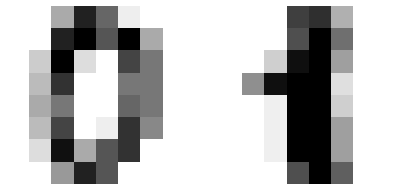

In [6]:
plotting_number(digits)

## Data procesing

Hay un total de 360 datapoints en el dataset, cada imagen es de 8x8 pixeles, colpasadas en un array, donde cada elemento es un entero entre 0 como blanco, 16 como negro. 

- Split en data de entrenamiento y de test 
- Normalización  
- Escalar entre 1 y -1 para poder usar clasificación cuántica 
- Reducir la dimensionalidad al número de qubits que queremos usar en este caso 4 qubits.

### Split data Train/Test

In [7]:
sample_train, sample_test, label_train,label_test = train_test_split(
    digits.data, 
    digits.target, 
    test_size=0.2, 
    random_state=22)

In [8]:
sample_train[0:1] 
#sample_test[0:1]

array([[ 0.,  0.,  5., 12.,  1.,  6.,  0.,  0.,  0.,  0., 11., 12.,  0.,
        16.,  2.,  0.,  0.,  0., 16.,  5.,  0., 12.,  4.,  0.,  0.,  3.,
        15.,  0.,  0.,  8.,  4.,  0.,  0.,  7., 12.,  0.,  0.,  4.,  7.,
         0.,  0.,  2., 15.,  1.,  1., 12.,  5.,  0.,  0.,  0., 16., 11.,
        12., 15.,  3.,  0.,  0.,  0.,  4., 12., 12.,  3.,  0.,  0.]])

In [9]:
label_train[0:10] # Nuestros 0 y 1

array([0, 0, 0, 0, 0, 1, 1, 1, 1, 1])

### Reduce Dimensionality

In [10]:
n_dim = 4
pca = PCA(n_components=n_dim).fit(sample_train)


In [11]:
sample_train = pca.transform(sample_train)


In [12]:
sample_test = pca.transform(sample_test)

In [13]:
sample_train[0:1] 

array([[-23.61001349,  -1.69933739,   2.83269772,  -2.19623692]])

### Normalize

In [14]:
std_scale = StandardScaler().fit(sample_train)
sample_train = std_scale.transform(sample_train)
sample_test = std_scale.transform(sample_test)

In [15]:
sample_train[0:1]

array([[-1.07075222, -0.13328206,  0.27741131, -0.29764469]])

### Scale

In [16]:
samples = np.append(sample_train, sample_test, axis=0)
samples[0:1]

array([[-1.07075222, -0.13328206,  0.27741131, -0.29764469]])

In [17]:
minmax_scale= MinMaxScaler((-1,1)).fit(samples)
minmax_scale

MinMaxScaler(feature_range=(-1, 1))

In [18]:
sample_train = minmax_scale.transform(sample_train)
sample_test = minmax_scale.transform(sample_test)
sample_train[0:1]

array([[-0.79923362, -0.26571862, -0.16474421, -0.17815209]])

### Select

In [19]:
train_size = 100
sample_train = sample_train[:train_size]
label_train = label_train[:train_size]


test_size = 20
sample_test = sample_test[:test_size]
label_test = label_test[:test_size]


In [20]:
print(f'''
Sample Train Value: {sample_train[0]}
Label Train Value: {label_train[0]}
________________

Sample Test Value: {sample_test[0]}
Label Test Value: {label_test[0]}
________________

''')





Sample Train Value: [-0.79923362 -0.26571862 -0.16474421 -0.17815209]
Label Train Value: 0
________________

Sample Test Value: [ 0.41948352 -0.83602799  0.72200828 -0.373356  ]
Label Test Value: 1
________________




## Data Encoding


Para realizar QML necesitamso realizar un encoding de la data clásica a un estado cuántico usando un quantum feature map. La importancia de escoger bien el feature map depende del dataset que queremos clasificar.


### Quantum Feature Maps

El QFM es una función $\phi(x)$ aue mapea features clásicos o vectores $x$ al estado cuántico $\ket{\phi(x)}\bra{\phi(x)}$ en un espacio de Hilbert. Esto es facilitado por la operación unitaria $U_{\phi(x)}$ en el estado inicial del qubit $\ket{0}$ donde $n$ es el número de qubits a ser usados en el encoding.

- Qiskit:
  - PauliFeatureMap
  - ZZFeatureMap
  - ZFeatureMap



### PauliFeatureMap

El feature Map de pauli  describe el operador unitario de "depth d"

$$U_{\phi(x)} = \prod_{d}U_{\phi(x)}H^{\otimes(n)}$$


$$U_{\phi(x)} = exp(\sum_{S\subseteq[n]}\phi_{s}(x)\prod_{k\in(S)}P_i)$$

El cual contiene capadas de compuertas de Hadamard intercaladas con bloques que facilitan el entrelazamiento denotados por los bloques $U_{\phi(x)}$ haciendo el encoding de la data clásica a un circuito cuántico  como se puede ver en la imagen, esto para un depth de $d=2$.

![assets](./assets/PauliFeatureMap.png)

Con los bloques de entrelazamiento tenemos que  $U_{\phi(x)}: P_i \in {I,X,Y,Z}$ denotan las matrices de Pauli, el índice S nos está hablando de la conectividad entre diferentes qubits o puntos de datos $S\in \begin{pmatrix}n\\k\end{pmatrix} combinationes, k= 1...n$. 


Por defecto la función que mapea $\phi(x)$ tiene las siguientes características:

- Si $S={i}$ entonces $x$

- Si $S={i,j}$ entonces $(\pi-x_i)(\pi-x_j)$

```python
PauliFeatureMap(feature_dimension=None,reps=2,entaglement='full',
    paulis=None,
    data_map_func=None,
    parameter_prefix='x',
    insert_barriers=False)
```

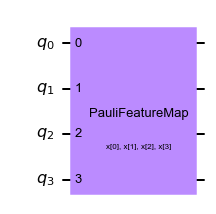

In [34]:
# Pauli Featur Map
p = PauliFeatureMap(4,reps=2,entanglement='full',
    paulis=['ZZ'])

p.draw('mpl')

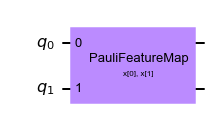

In [30]:
p = PauliFeatureMap(2,reps=1,
    paulis=['Z','XX'])

p.draw('mpl')

### ZFeatureMap

Cuando $k=1, P_0=Z$ tenemos el ZfeatureMap:

$$U_{\phi(x)} =(exp(i\sum_{j}\phi_{j}(x)Z_j)H^{\otimes(n)})$$

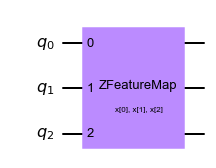

In [27]:
map_z = ZFeatureMap(3, reps=2)
map_z.draw('mpl')

No hay dos qubits gates y no podemos representar ventajas cuánticas, necesitamos el entanglement.

### ZZfeature Map

Sucede cuando tenemos $k=2, P_0=Z,P_1=ZZ$:

$$U_{\phi(x)} =(exp(i\sum_{jk}\phi_{jk}(x)(Z_j)\otimes(Z_k))exp(i\sum_{j}\phi_{j}(x)Z_j)H^{\otimes(n)})^d$$

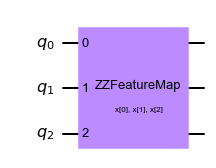

In [35]:
map_zz = ZZFeatureMap(feature_dimension=3, reps=1)
map_zz.draw('mpl')

Podemos realizar diferentes tipos de entrelazamiento, lineal, circular y full. Es posible customizar las copmuertas para el feature map en el argumento de paulis, con una lista de las compeurtas que queremos.

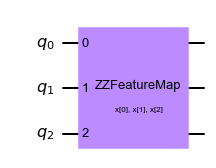

In [36]:
# 3 features , 1 depth
map_zz = ZZFeatureMap(feature_dimension=3, reps=1, entanglement='full')
map_zz.draw('mpl')

### Custom data mapping function

Podemos realizar estas funciones de manera personalziada, por ejemplo queremors definir un $\phi_S$ 

$$\phi_S: x \rightarrow   x_i  , S=(i) $$

$$\phi_S: x \rightarrow  \sin(\pi -x_i)\sin(\pi -x_j) , S=(i,j) $$

In [44]:
def custom_func(x):
    coeff = x[0] if len(x) ==1 else reduce(lambda m, n: m*n, np.sin(np.pi-x))
    return coeff


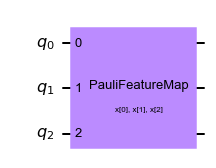

In [45]:
map_customed = PauliFeatureMap(3, reps=2, paulis=['ZZ'], data_map_func=custom_func)
map_customed.draw('mpl')

## NLocal and TwoLocal

Son funciones de Qiskit que podemos parametrizar para usarlas como featuremap.